Took https://towardsdatascience.com/character-level-language-model-1439f5dd87fe and translated into pytorch with following modifications:

* reset h_prev for each training example - observed better smooth loss but more variation in raw loss
* stopped gradient clipping - no noticeable performance impact
* replace the rnn with a gru - loss gets much lower during training and generated names are more interesting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
class MyModel(nn.Module):
    def __init__(self, hidden_layer_size, vocab_size):
        super(MyModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.vocab_size = vocab_size
        
        self.gru = nn.GRU(input_size=vocab_size, hidden_size=hidden_layer_size)
        self.h2logits = nn.Linear(hidden_layer_size, vocab_size)

    def forward(self, x, h):
        h, _ = self.gru(x, h)        
        logits = self.h2logits(h)
        return logits, h
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_layer_size)

In [3]:
lossfun = nn.CrossEntropyLoss()
def compute_example_loss(x, y, h, model): 
    # x is assumed to be a list of indices except for first element which is None
    # y is also a list of indices
    # h included as they aren't resetting to zero
    example_loss = 0
    
    # Forward pass: loop over all characters of the name
    for t in range(len(x)):
        xt = torch.zeros(1, vocab_size) # Convert to one-hot vector
        if t > 0:
            xt[0, x[t]] = 1
        logits, h = model.forward(xt, h)
        example_loss += lossfun(logits, torch.tensor([y[t]]))

    return example_loss, h

def smooth_loss(previous_loss, current_loss):
    return 0.999 * previous_loss + 0.001 * current_loss

def train(
    examples, chars_to_idx, idx_to_chars, hidden_layer_size, vocab_size,
    num_epochs=10):
    
    model = MyModel(hidden_layer_size, vocab_size)
    opt = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9) # he is smoothing, not using momentum
    
    # initialize
    smoothed_loss = -np.log(1 / vocab_size) * 7

    overall_loss = []
    raw_losses = []
    gradient_size = []
        
    for epoch in range(num_epochs):
        print(f"\033[1m\033[94mEpoch {epoch}")
        print(f"\033[1m\033[92m=======")

        # Sample one name
        print(f"""Sampled name: {sample(model, idx_to_chars, chars_to_idx,
            10).capitalize()}""")
        print(f"Smoothed loss: {smoothed_loss:.4f}\n")

        # Shuffle examples
        np.random.shuffle(examples)

        # Iterate over all examples (SGD)
        for example in examples:
            x = [None] + [chars_to_idx[char] for char in example]
            y = x[1:] + [chars_to_idx["\n"]]
            
            # MOD: set h_prev to all zeros before training on each example
            h_prev = model.initHidden()
            
            # Fwd pass
            model.zero_grad()
            example_loss, h = compute_example_loss(x, y, h_prev, model)

            # Compute smooth loss -- this is JUST for plotting not for computing
            # gradients--the example loss is still used for computing gradients
            smoothed_loss = smooth_loss(smoothed_loss, example_loss.item())
            
            # Bwd pass with gradient clipping
            example_loss.backward()
            # MOD: removed gradient clipping
            opt.step()


        overall_loss.append(smoothed_loss)
        raw_losses.append(example_loss.item())
    return model, overall_loss, raw_losses

def sample(model, idx_to_chars, chars_to_idx, n):
    vocab_size = model.vocab_size
    hidden_layer_size = model.hidden_layer_size
    h_prev = model.initHidden()
    x = torch.zeros(1, vocab_size)
    
    indices = []
    idx = -1
    counter = 0
    while (counter <= n and idx != chars_to_idx['\n']):
        logits, h_prev = model.forward(x, h_prev)
        probs = nn.Softmax(dim=1)(logits)
        
        # Sample the index of the character using generated probs distribution
        idx = np.random.choice(vocab_size, p=probs.ravel().detach().numpy())

        # Add the char to the sequence
        indices.append(idx)
        
        # Update a_prev and x
        x = torch.zeros(1, vocab_size)
        x[0, idx] = 1
        
        counter += 1 
        
    sequence = "".join([idx_to_chars[idx] for idx in indices if idx != 0])
    return sequence

In [4]:
file_path = "dino_names_scraped_from_wikipedia.txt"
data = open(file_path, "r").read()

# Convert characters to lower case
data = data.lower()

# Construct vocabulary using unique characters, sort it in ascending order,
# then construct two dictionaries that maps character to index and index to
# characters.
chars = list(sorted(set(data)))
chars_to_idx = {ch:i for i, ch in enumerate(chars)}
idx_to_chars = {i:ch for ch, i in chars_to_idx.items()}

# Get the size of the data and vocab size
data_size = len(data)
vocab_size = len(chars_to_idx)
print(f"There are {data_size} characters and {vocab_size} unique characters.")

There are 22048 characters and 27 unique characters.


In [5]:
# Get the data
with open(file_path) as f:
    data = f.readlines()
examples = [x.lower().strip() for x in data]

hidden_layer_size = 100 # same as imad

# Fitting the model
model, loss, raw_loss = train(examples, chars_to_idx, idx_to_chars, hidden_layer_size, vocab_size,
    num_epochs=100)

Epoch 0
Sampled name: Yqyakvvuxcx
Smoothed loss: 23.0709

Epoch 1
Sampled name: Intolpdnysa
Smoothed loss: 26.3241

Epoch 2
Sampled name: Ausurosauru
Smoothed loss: 24.3298

Epoch 3
Sampled name: Barodongus
Smoothed loss: 23.1139

Epoch 4
Sampled name: Eclepharia
Smoothed loss: 22.1866

Epoch 5
Sampled name: Gtivuenisau
Smoothed loss: 21.5373

Epoch 6
Sampled name: Veasirepelt
Smoothed loss: 20.9940

Epoch 7
Sampled name: Hankerosaur
Smoothed loss: 20.4948

Epoch 8
Sampled name: Centhosauru
Smoothed loss: 20.2339

Epoch 9
Sampled name: Kostotiton
Smoothed loss: 19.6600

Epoch 10
Sampled name: Gorniphosau
Smoothed loss: 19.3548

Epoch 11
Sampled name: Droosaurus
Smoothed loss: 19.0854

Epoch 12
Sampled name: Bankasaurus
Smoothed loss: 18.8301

Epoch 13
Sampled name: Ferhypes
Smoothed loss: 18.4408

Epoch 14
Sampled name: Rcomiansaur
Smoothed loss: 18.1112

Epoch 15
Sampled name: Pmokratactr
Smoothed loss: 17.9207

Epoch 16
Sampled name: Kongyanosau
Smoothed loss: 17.6384

Epoch 17
Sampl

Epoch 98
Sampled name: Arcadaethov
Smoothed loss: 10.7215

Epoch 99
Sampled name: Anchieratia
Smoothed loss: 10.7340



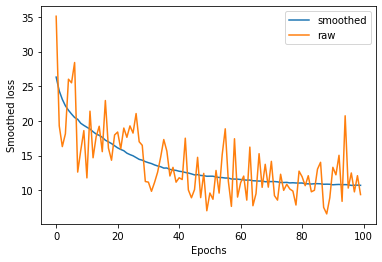

In [6]:
# Plotting the loss
plt.plot(range(len(loss)), loss, label='smoothed')
plt.plot(range(len(loss)), raw_loss, label='raw')
plt.xlabel("Epochs")
plt.ylabel("Smoothed loss")
plt.legend();

In [7]:
torch.save(model, 'dino_rnn.pth')